# Laboratorio 9 - Reconocimiento de Voz Simple vs Whisper-tiny
Francisco Castillo - 21562

## Dataset

In [11]:
from pathlib import Path
from datasets import Dataset, load_from_disk

data_dir = Path(r"D:\UVG\NLP\NLP-Voice-Recognition\workspace\data")
audio_dir = data_dir / "audio"
trans_dir = data_dir / "transcript"
out_dir = data_dir / "local_dataset"

In [12]:
# try to load existing persisted dataset
if out_dir.exists():
    try:
        dataset = load_from_disk(str(out_dir))
        print("Loaded persisted dataset with", len(dataset), "samples from", str(out_dir))
    except Exception as e:
        print("Failed to load persisted dataset:", e)
        dataset = None
else:
    dataset = None

# create and persist if not loaded
if dataset is None:
    records = []
    audio_files = sorted(audio_dir.glob("*.wav"), key=lambda p: int(p.stem))
    trans_map = {p.stem: p for p in trans_dir.glob("*.txt")}

    for a in audio_files:
        stem = a.stem
        tpath = trans_map.get(stem)
        if not tpath:
            continue
        text = tpath.read_text(encoding="utf-8").strip()
        records.append({"audio_path": str(a.resolve()), "text": text})

    dataset = Dataset.from_list(records)
    out_dir.mkdir(parents=True, exist_ok=True)
    dataset.save_to_disk(str(out_dir))
    print("Saved", len(dataset), "samples to", str(out_dir))

print(dataset[0])

Loaded persisted dataset with 5 samples from D:\UVG\NLP\NLP-Voice-Recognition\workspace\data\local_dataset
{'audio_path': 'D:\\UVG\\NLP\\NLP-Voice-Recognition\\workspace\\data\\audio\\1.wav', 'text': 'CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED'}


## Ejercicio 1 - Extracción de características

### a) Diferencia entre espectrograma lineal y el log-mel
El espectrograma lineal muestra la energía de la señal en distintas frecuencias a lo largo del tiempo, usando una escala de frecuencias lineal obtenida mediante la Transformada de Fourier. Aunque representa correctamente el contenido físico del sonido, no refleja cómo el oído humano percibe las diferencias de tono: somos mucho más sensibles a cambios en las frecuencias bajas que en las altas. Por eso, esta representación no es del todo óptima para tareas donde la interpretación perceptual del audio es importante, como el reconocimiento de voz.

El log-mel espectrograma aplica una escala Mel que comprime las frecuencias altas y da más resolución a las bajas, simulando mejor la audición humana. Además, convierte las intensidades a escala logarítmica, reduciendo la diferencia entre sonidos fuertes y suaves, lo que facilita el aprendizaje de patrones. En modelos de ASR, esta transformación ayuda a extraer rasgos fonéticos más relevantes, mejora la estabilidad numérica y reduce el tamaño de entrada sin perder información esencial, razón por la cual es la representación estándar usada por modelos como Whisper.


### Características Log-Mel

In [13]:
import librosa
import numpy as np


def compute_log_mel(example, sr=16000, n_fft=400, hop_length=160, n_mels=80):
    y, _ = librosa.load(example["audio_path"], sr=sr)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0
    )
    example["logmel"] = librosa.power_to_db(mel, ref=np.max)
    return example

In [14]:
dataset = dataset.map(compute_log_mel)

for sample in dataset:
    print(f"Audio: {sample['audio_path']}, Log-Mel shape: {np.array(sample['logmel']).shape}")

Audio: D:\UVG\NLP\NLP-Voice-Recognition\workspace\data\audio\1.wav, Log-Mel shape: (80, 1454)
Audio: D:\UVG\NLP\NLP-Voice-Recognition\workspace\data\audio\2.wav, Log-Mel shape: (80, 1609)
Audio: D:\UVG\NLP\NLP-Voice-Recognition\workspace\data\audio\3.wav, Log-Mel shape: (80, 1330)
Audio: D:\UVG\NLP\NLP-Voice-Recognition\workspace\data\audio\4.wav, Log-Mel shape: (80, 1113)
Audio: D:\UVG\NLP\NLP-Voice-Recognition\workspace\data\audio\5.wav, Log-Mel shape: (80, 1409)


### Matriz log-mel

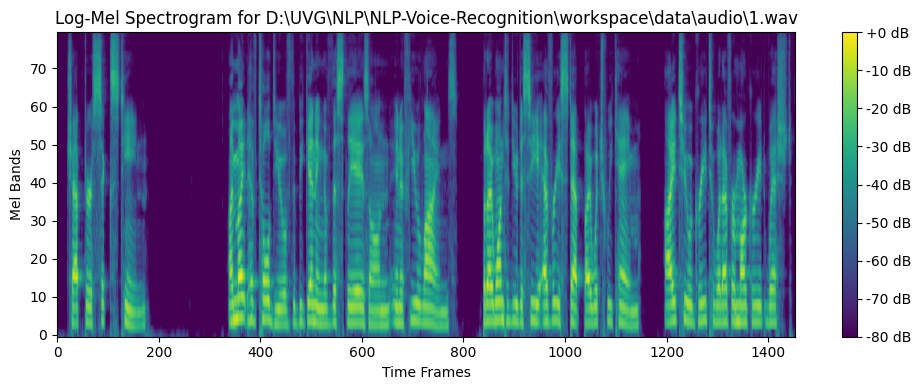

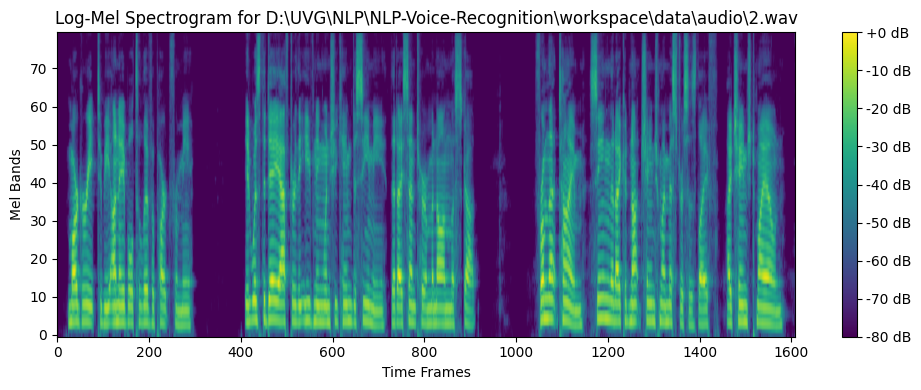

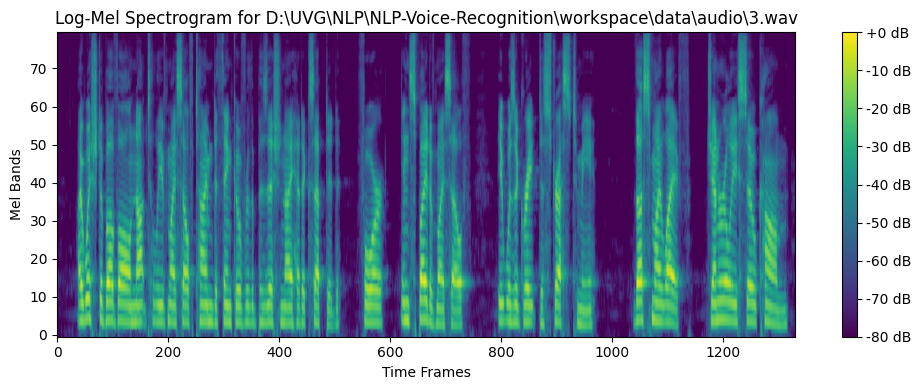

In [15]:
import matplotlib.pyplot as plt

for sample in dataset.select(range(3)):
    logmel = np.array(sample["logmel"])
    plt.figure(figsize=(10, 4))
    plt.imshow(logmel, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log-Mel Spectrogram for {sample["audio_path"]}')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Bands')
    plt.tight_layout()
    plt.show()

#### Interpretación del eje temporal
El eje horizontal (Time Frames) indica la evolución temporal del audio: cada unidad representa un frame de la señal, por lo que el desplazamiento de izquierda a derecha muestra cómo cambian los patrones sonoros conforme avanza la grabación. Las zonas con mayor intensidad (en verde o amarillo) corresponden a momentos donde hay más energía acústica, como vocales o consonantes sonoras.

el eje vertical (Mel Bands) representa las frecuencias distribuidas en la escala Mel. Las bandas bajas (parte inferior) contienen información sobre los tonos graves y la base de la voz, mientras que las bandas altas (parte superior) reflejan armónicos y detalles de pronunciación.

## Ejercicio 2 - Modelo CYC con Transofrmer Encoder

### Estructura general del modelo

### Entrenamiento

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from jiwer import wer

class SmallTransformerCTC(nn.Module):
    def __init__(self, input_dim=80, n_heads=4, hidden_dim=256, n_layers=2, output_dim=27):
        super().__init__()
        layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, src_key_padding_mask=None):
        out = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        logits = self.fc(out)
        return nn.functional.log_softmax(logits, dim=-1)

In [17]:
def collate_fn(batch):
    xs = [torch.tensor(np.asarray(b["logmel"]).T, dtype=torch.float32) for b in batch]
    ys = [torch.tensor([ord(c) - 96 for c in b["text"].lower() if c.isalpha()],
                       dtype=torch.long) for b in batch]
    ys = [y if y.numel() > 0 else torch.tensor([0], dtype=torch.long) for y in ys]

    x_lens = torch.tensor([x.size(0) for x in xs], dtype=torch.long)
    y_lens = torch.tensor([y.size(0) for y in ys], dtype=torch.long)

    xs_pad = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    ys_pad = nn.utils.rnn.pad_sequence(ys, batch_first=True)
    return xs_pad, ys_pad, x_lens, y_lens

In [18]:
loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SmallTransformerCTC().to(device)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X, Y, X_len, Y_len in loader:
        X, Y, X_len, Y_len = X.to(device), Y.to(device), X_len.to(device), Y_len.to(device)

        mask = torch.arange(X.size(1), device=device)[None, :] >= X_len[:, None]

        optimizer.zero_grad()
        log_probs = model(X, src_key_padding_mask=mask)  # (batch, T, C)
        log_probs = log_probs.permute(1, 0, 2)  # (T, batch, C)

        loss = ctc_loss(log_probs, Y, X_len, Y_len)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs} | Mean CTC loss: {epoch_loss / len(loader):.4f}")

Epoch 1/10 | Mean CTC loss: 21.8218
Epoch 2/10 | Mean CTC loss: 20.5239
Epoch 3/10 | Mean CTC loss: 18.2424
Epoch 4/10 | Mean CTC loss: 17.1426
Epoch 5/10 | Mean CTC loss: 15.4333
Epoch 6/10 | Mean CTC loss: 14.0934
Epoch 7/10 | Mean CTC loss: 13.2906
Epoch 8/10 | Mean CTC loss: 11.7222
Epoch 9/10 | Mean CTC loss: 11.0060
Epoch 10/10 | Mean CTC loss: 10.2056


In [20]:
def greedy_decode(log_probs):
    pred_ids = log_probs.argmax(-1).cpu().numpy()
    decoded = []
    for seq in pred_ids:
        prev = -1
        out = []
        for p in seq:
            if p != prev and p != 0:  # skip blanks and duplicates
                out.append(chr(p + 96))  # 1->a, 2->b, ...
            prev = p
        decoded.append("".join(out))
    return decoded

In [21]:
refs, hyps = [], []
model.eval()
with torch.no_grad():
    for X, Y, X_len, Y_len in loader:
        X, Y = X.to(device), Y.to(device)
        mask = torch.arange(X.size(1), device=device)[None, :] >= X_len[:, None]
        log_probs = model(X, src_key_padding_mask=mask)
        preds = greedy_decode(log_probs)
        refs += ["".join(chr(c.item() + 96) for c in y if c > 0) for y in Y]
        hyps += preds

# Normalize strings for fair comparison
refs = [r.lower().strip() for r in refs]
hyps = [h.lower().strip() for h in hyps]

print("Sample predictions:")
for r, h in zip(refs[:3], hyps[:3]):
    print(f"REF: {r}\nHYP: {h}\n")

print("Final WER:", wer(refs, hyps))

Sample predictions:
REF: iwishedaboveallnottoleavemyselftimetothinkoverthepositionihadacceptedforinspiteofmyselfitwasagreatdistresstomethusmylifegenerallysocalm
HYP: np

REF: chaptersixteenimighthavetoldyouofthebeginningofthisliaisoninafewlinesbutiwantedyoutoseeeverystepbywhichwecameitoagreetowhatevermargueritewished
HYP: n

REF: assumedallatonceanappearanceofnoiseanddisorderneverbelievehoweverdisinterestedtheloveofakeptwomanmaybethatitwillcostonenothing
HYP: np

Final WER: 1.0


### Decodificacióñ greedy y evaluaación

In [22]:
print("WER:", wer(refs, hyps))

WER: 1.0


### Discusión
#### ¿Qué ventajas observas frente a un modelo (Basado en RNN)?
Se diferencia en la eficiencia y capacidad para modelar dependencias largas. Las RNN procesan la secuencia de manera secuencial, los Transformers pueden hacerlo en paralelo gracias a la autoatención y evita la pérdida de información en secuencias extensas. Además, permite al modelo enfocarse en distintas partes del audio simultáneamente, capturando mejor las relaciones globales entre fonemas o palabras, algo que las RNN degradan con el tiempo.
#### ¿Qué tipo de errores dominan?
El modelo no logró generalizar ni reconocer correctamente las transcripciones. Los errores son predicciones vacías o irrelevantes, salidas como “n” o “np” frente a textos largos. Esto sugiere que el modelo aún no aprendió una alineación efectiva entre las características del audio y las secuencias de texto, probablemente por un conjunto de datos pequeño demasiado pequeño, o un número insuficiente de épocas.
#### ¿Cómo permite la autoatención modelar dependencias largas sin recurrencia?
La autoatención permite que cada posición del input se relacione con todas las demás mediante pesos de atención que miden su relevancia mutua, sin depender del procesamiento paso a paso de las RNN. En lugar de pasar información de manera recurrente, el Transformer construye una representación global de la secuencia en una sola pasada, lo que facilita aprender patrones de larga distancia, como dependencias entre fonemas separados por pausas o sílabas distantes. Esto hace que la red sea más efectiva al capturar la estructura completa del habla, incluso en frases largas o complejas.

## Ejercicio 3 - Baseline Whisper-tiny

### b) Transcriba los mismos audios

In [23]:
import whisper

model = whisper.load_model("tiny")

In [24]:
import time
total_wer = 0.0
count = 0

for i, sample in enumerate(dataset):
    audio_path = sample["audio_path"]
    ref = sample["text"].strip().lower()

    start_time = time.time()
    result = model.transcribe(audio_path, fp16=False, language="en")
    elapsed = time.time() - start_time

    hyp = result["text"].strip().lower()
    sample_wer = wer(ref, hyp)
    total_wer += sample_wer
    count += 1

    print(f"\nSample {i+1}:")
    print(f"REF: {ref}")
    print(f"HYP: {hyp}")
    print(f"WER: {sample_wer:.3f}")
    print(f"Time: {elapsed:.2f} sec")

# Compute mean WER
if count > 0:
    print(f"\nAverage WER over {count} samples: {total_wer / count:.3f}")


Sample 1:
REF: chapter sixteen i might have told you of the beginning of this liaison in a few lines but i wanted you to see every step by which we came i to agree to whatever marguerite wished
HYP: chapter 16 i might have told you of the beginning of this liaison in a few lines, but i wanted you to see every step by which we came. i to agree to whatever mark reid wished
WER: 0.139
Time: 0.81 sec

Sample 2:
REF: marguerite to be unable to live apart from me it was the day after the evening when she came to see me that i sent her manon lescaut from that time seeing that i could not change my mistress's life i changed my own
HYP: margarit to be unable to live apart from me. it was the day after the evening when she came to see me that i sent her a mononless scut. from that time, seeing that i could not change my mistress's life, i changed my own.
WER: 0.182
Time: 1.00 sec

Sample 3:
REF: i wished above all not to leave myself time to think over the position i had accepted for in spite o

## Ejercicio 4 - Comparación y análisis final
### Tabla comparativa
| Característica                           | SmallTransformerCTC                        | Whisper Tiny                          |
| ---------------------------------------- |--------------------------------------------| ------------------------------------- |
| **WER promedio**                         | 1.00                                       | **0.178**                             |
| **Tamaño del modelo (MB)**               | 148 MB                                     | **82 MB**                             |
| **Tiempo de entrenamiento / inferencia** | 32 s de entrenamiento, inferencia inmediata | Preentrenado, **0.9 s de inferencia** |

### ¿Por qué Whisper obtiene mejor robustez frente a ruido o acentos?
Porque fue entrenado con una cantidad masiva y diversa de datos de audio provenientes de distintas fuentes, idiomas, acentos y condiciones acústicas, lo que le permite generalizar mejor ante variaciones en el habla. Además, su arquitectura Transformer y su entrenamiento multitarea (reconocimiento, traducción y segmentación) le ayudan a capturar dependencias contextuales más largas y a distinguir patrones relevantes incluso en entornos ruidosos, a diferencia del modelo CTC que depende más de la alineación local entre entrada y salida.
### Mejoras para el modelo CTC
Podríamos usar embeddings contextuales o capas bidireccionales LSTM/Transformer que capturen dependencias más amplias. También sería útil incrementar la diversidad del dataset, ajustar la tasa de aprendizaje y aplicar language models externos para mejorar la decodificación final. Definitivamente, un dataset y entrenamiento MUCHO más robusto.



In [25]:
torch.save(model.state_dict(), "small_transformer_ctc.pth")